# Search Algorithm : Farmer Goat Wolf Cabbage
---

### Problem Statement:
In a classic problem of constrained transportation involving a farmer, a goat, a wolf, and a cabbage, the farmer is faced with the challenge of safely ferrying all three items across a river using a single boat. The constraints dictate that 
1. the farmer can only transport one additional item alongside himself in the boat, 
2. **leaving the goat with the wolf** or **the cabbage with the goat** unsupervised will result in the consumption of one by the other. 

The objective is for the farmer to devise a series of crossings that allow the farmer to successfully transport all three items to the other side of the river without any instances of predation occurring.

Source: https://www.geeksforgeeks.org/puzzle-farmer-goat-wolf-cabbage/

### Task & Requirements
In this exercise, you are task to develop and try diffrent search algorithm to solve above problem, observe if the algorithm is *complete* and if the algorithm is *optimum* by using the preparatory code given below. You are also encourage to attempt the challenge task to earn more marks for this lab exercise. This exercises are to be completed in a team which consist the same members for the mini-project in this course.

At the end of this exercise, you are required explain each search algorithms developed by preparing and recording your presentation. The presentation video should **not exceed 5 minutes**. At the beginning of the video, each member **must briefly introduce themself** with **camera on**.

Submit the completed **ipybn** and **presentation video** to the NTU Learn Lab Course Page.

---

### Essential Libraries

Let us begin by importing the essential Python Libraries.

In [97]:
# Install Networkx for graph visualization if you do not have the package installed.
# !pip install networkx

In [98]:
import networkx as nx
import matplotlib.pyplot as plt
import queue

### Environment Setups
1. Objects name (unused for non-challenge task, can be use for challenge task)
2. forbidden states (unused for non-challenge task / for reference only, can be use for challenge task)
3. allowable states - states that allowed during the game
4. moves graph - possible game states transition

Visualizing Game States and potential paths
  The left and right river banks are separated by a pipeline |
  Initial State - (WGLF| ), NOTE: in this figure, L == Cabbage
  Red - Forbidden States, Green - Goal State(s)
Image Source: https://math.stackexchange.com/questions/786881/wolf-cabbage-and-goat-using-dijkstra


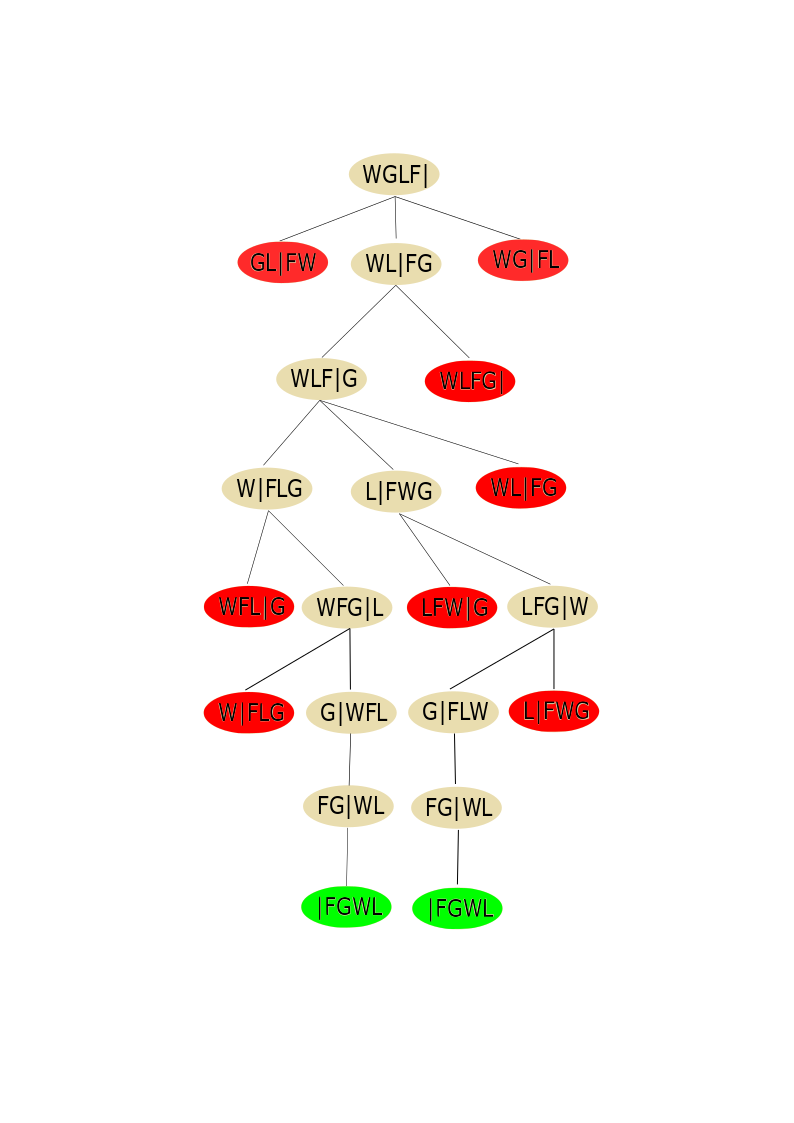

In [99]:
from IPython.display import Image
print("Visualizing Game States and potential paths")
print("  The left and right river banks are separated by a pipeline |")
print("  Initial State - (WGLF| ), NOTE: in this figure, L == Cabbage")
print("  Red - Forbidden States, Green - Goal State(s)")

print("Image Source: https://math.stackexchange.com/questions/786881/wolf-cabbage-and-goat-using-dijkstra")
Image(filename='./images/mfx0J.png')

### Simplified Version of FWGC Scenario
The graphs above shows 21 possible states (represented as nodes) and two possible paths to reach the goal state.
To simplify the case study, we just make use of all allowed states, and excluding all forbidden states for the rest of our experiments below.
If you wish to, you can try to model all 21 states after completing the entire activities later as part of the Challenge Task.

In [100]:
## Objects
names = {"F": "Farmer",
         "W": "Wolf",
         "G": "Goat",
         "C": "Cabbage"}

forbidden_states = [
    {"W","G"}, 
    {"G","C"}, 
    {"G","C","W"}
    ]

# "State": [{Left River Bank State}, {Right River Bank State}]
allowable_states = {
    "1" : [{"F", "W", "G", "C"}, {None}],
    "2" : [{"W","C"},{"F","G"}],
    "3" : [{"F","G","C"},{"W"}],
    "4" : [{"F","W","C"},{"G"}],
    "5" : [{"F","W","G"},{"C"}],
    "6" : [{"C"},{"F","W","G"}],
    "7" : [{"W"},{"F","G","C"}],
    "8" : [{"G"},{"F","W","C"}],
    "9" : [{"F","G"},{"W","C"}],
    "10" : [{None},{"F","W","G","C"}]
}

# (current node, adjecent node, weight/cost/time taken to cross river)
# the weight is the cost / time needed for the farmer to rawl the boat and cross the river. 
# The heavier the boat is the longer time it takes to cross the river
moves_graph = [
    ("1", "2", {"weight":8.1}),     # Farmer + Goat         Left -> Right
    ("2", "4", {"weight":5.6}),     # Farmer alone          Right -> Left
    ("4", "6", {"weight":8.6}),     # Farmer + Wolf         Left -> Right
    ("4", "7", {"weight":5.7}),     # Farmer + Cabbage      Left -> Right
    ("6", "3", {"weight":8.1}),     # Farmer + Goat         Right -> Left
    ("7", "5", {"weight":8.1}),     # Farmer + Goat         Right -> Left
    ("3", "8", {"weight":5.7}),     # Farmer + Cabbage      Left -> Right
    ("5", "8", {"weight":8.6}),     # Farmer + Wolf         Left -> Right
    ("8", "9", {"weight":5.6}),     # Farmer alone          Right -> Left
    ("9", "10", {"weight":8.1})     # Farmer + Goat         Left -> Right
]


### Game Graph
Plotting the game state transition graphs

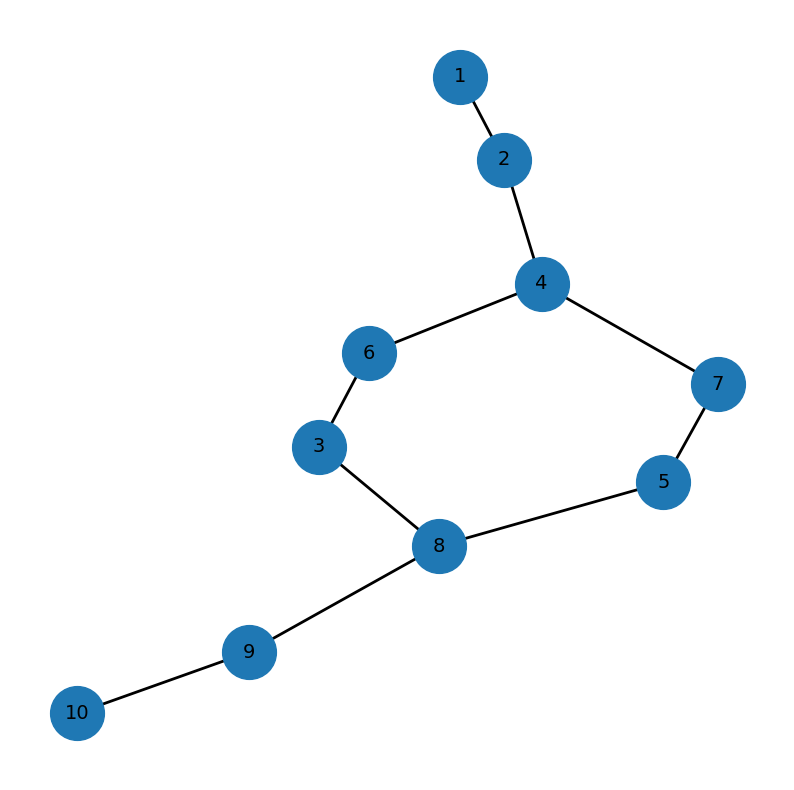

States [{Left River Bank}, {Right River Bank}]
1      [{'W', 'C', 'F', 'G'}, {None}]
2      [{'W', 'C'}, {'F', 'G'}]
3      [{'C', 'F', 'G'}, {'W'}]
4      [{'W', 'C', 'F'}, {'G'}]
5      [{'W', 'F', 'G'}, {'C'}]
6      [{'C'}, {'W', 'F', 'G'}]
7      [{'W'}, {'C', 'F', 'G'}]
8      [{'G'}, {'W', 'C', 'F'}]
9      [{'F', 'G'}, {'W', 'C'}]
10     [{None}, {'W', 'C', 'F', 'G'}]


In [101]:


# Function to shows the graphs of possible moves/states that satisfy the game rules.
def printGraph(graph):
    G = nx.Graph()
    G.add_edges_from(graph)

    f = plt.figure(figsize = (10,10))
    pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size = 1500)
    nx.draw_networkx_edges(G, pos, width = 2)
    nx.draw_networkx_labels(G, pos, font_size = 14)

    plt.axis("off")
    plt.show()

# Print Graphs and show list of states
printGraph(moves_graph)

print("States [{Left River Bank}, {Right River Bank}]")
for state in allowable_states:
    print(f"{state:6} {allowable_states[state]}")

### Helper Functions

These are helper function, no modification needed at this portion

In [102]:
# Get Neighbour Function
def getNeighbours(graph, current_node):
    ''' Function to generate list of adjecent node(s) / neighbour(s) when given a node.
        Input  : moves graphs and current node
        Output : list of adjecent node(s)
    '''
    neighbors = []
    for i, j, w in graph:
        if i == current_node:
            neighbors.append((j, w))
    
    return neighbors

def performSearch(func, name, graph, start, goal, heuristics=None):
    ''' Function to generate list of adjecent node(s) / neighbour(s) when given a node.
        Input  : moves graphs and current node
        Output : list of adjecent node(s)
    '''
    # Run the selected search algorithm for path finding
    if heuristics is None:      
        # For uninformed search algorithms i.e. BFS, DFS & UCS
        nodesExplored, pathsExplored, nodesProcessed = func(graph, start = start, goal = goal)
    else:
        # For informed search algorithms i.e. Greedy & A*Star Search
        nodesExplored, pathsExplored, nodesProcessed = func(graph, start = start, goal = goal, heuristics=heuristics)

    path = reconstruct_path(nodesExplored, start = start, goal = goal)

    # Basic measures for the algorithm
    print("=" * len(name))
    print(name)
    print("=" * len(name))
    print()

    totalNodes = len(graph) #changed from move_graph to graph
    print(f"Total nodes in graph    : {totalNodes}")
    print(f"Total nodes visited     : {nodesProcessed} | {100*(nodesProcessed/totalNodes)}%")
    if pathsExplored is not None:
        print(f"Path Cost / Heuristics  :")
        print("------------------------")
        print("Node | Cost / Heuristics")
        print("------------------------")
        for n in pathsExplored:
            print(f"{n:2}   | {pathsExplored[n]:5.1f}")
        print("------------------------")
    print()
    print("Final path steps taken  :", len(path))

    # Print the path and show using helper functions
    print("Path through the Graph :")
    print(f"(start)  ", end="")
    for node in path:
        if node != goal:
            print(f"{node} -> ", end="")
        else:
            print(f"{node} (Goal)")


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents
def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

### Breadth-First-Search (BFS) - Non-Challenge Task
**Uninformed Search** : Focusses on the graph structure and not the *cost from start* or *distance from goal*.

In [103]:
# Breadth-First-Search (BFS) with FIFO Queue

def breadth_first_search(graph, start, goal):
    ''' Function to perform BFS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.Queue()    # FIFO Queue for Frontier
    
    # initialization
    frontier.put(start)         # Add the start node to frontier
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    processed = 0               # Count of total nodes processed
    

    ### YOUR CODE STARTS HERE
    neighbors = []
    while not frontier.empty():
        
        current_node = frontier.get()
        processed = processed + 1
        print("current_node: " + str(current_node) + ", goal: " + str(goal))
        if current_node == goal:
            explored[10] = current_node
            break

        neighbors = getNeighbours(graph, current_node)
        for neighbor in neighbors:
            if neighbor[0] not in explored:
                frontier.put(neighbor[0])
                #print("asdasd")
                explored[neighbor[0]] = current_node
    print("---------------------------------------------------------------------------------")
    ### YOUR CODE ENDS HERE
    
    return explored, None, processed

INIT_STATE = "1"
GOAL_STATE = "10"
performSearch(breadth_first_search, "Breadth First Search (BFS)", moves_graph, INIT_STATE, GOAL_STATE)

current_node: 1, goal: 10
current_node: 2, goal: 10
current_node: 4, goal: 10
current_node: 6, goal: 10
current_node: 7, goal: 10
current_node: 3, goal: 10
current_node: 5, goal: 10
current_node: 8, goal: 10
current_node: 9, goal: 10
current_node: 10, goal: 10
---------------------------------------------------------------------------------
Breadth First Search (BFS)

Total nodes in graph    : 10
Total nodes visited     : 10 | 100.0%

Final path steps taken  : 8
Path through the Graph :
(start)  1 -> 2 -> 4 -> 6 -> 3 -> 8 -> 9 -> 10 (Goal)


### Reflection Questions for BFS

1. How many nodes (total) in the graphs, and how many nodes has been visited before reaching the goal state?
2. Is this algorithm *complete*? Is it *optimal*? Is there anything you can do to increase its *efficiency*?

In [149]:
### Write your answer here:
answer1 = """
There are a total of 10 nodes in the graph, and using BFS we needed to visit all 10 states before reaching the goal state
"""

answer2 = """
Yes, the algorithm is complete as it will find a solution if there is
It is optimal as it will go through all nodes to find the shortest path. 
Increasing efficiency in terms of algorithm is not possible as it is part of BFS algorithm to expand all nodes until the goal is met.
"""
print(f"Question 1: {answer1}")
print(f"Question 2: {answer2}")

Question 1: 
There are a total of 10 nodes in the graph, and using BFS we needed to visit all 10 states before reaching the goal state

Question 2: 
Yes, the algorithm is complete as it will find a solution if there is
It is optimal as it will go through all nodes to find the shortest path. 
Increasing efficiency in terms of algorithm is not possible as it is part of BFS algorithm to expand all nodes until the goal is met.



### Depth-First-Search (DFS) - Non-Challenge Task

**Uninformed Search** : Focusses on the graph structure and not the *cost from start* or *distance from goal*.

In [105]:
# Depth-First-Search (DFS) with LIFO Queue

def depth_first_search(graph, start, goal):
    ''' Function to perform DFS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    ### YOUR CODE STARTS HERE
    
    # initialization
    frontier = []               # Stack for Frontier (LIFO)
    frontier.append(start)      # Add the start node to frontier
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    processed = 0               # Count of total nodes processed
    
    while frontier:
        # print("while")
        current_node = frontier.pop()
        processed += 1
        # print("current_node: " + str(current_node) + ", goal: " + str(goal))
        if current_node == goal:
            break

        neighbors = getNeighbours(graph, current_node)
        for neighbor in neighbors:
            if neighbor[0] not in explored:
                frontier.append(neighbor[0])
                # print("asdasd")
                explored[neighbor[0]] = current_node

    ### YOUR CODE ENDS HERE
    
    return explored, None, processed



performSearch(depth_first_search, "Depth First Search (DFS)", moves_graph, INIT_STATE, GOAL_STATE)

Depth First Search (DFS)

Total nodes in graph    : 10
Total nodes visited     : 8 | 80.0%

Final path steps taken  : 8
Path through the Graph :
(start)  1 -> 2 -> 4 -> 7 -> 5 -> 8 -> 9 -> 10 (Goal)


### Reflection Questions for DFS

1. How many nodes (total) in the graphs, and how many nodes has been visited before reaching the goal state?
2. Is this algorithm *complete*? Is it *optimal*? Is there anything you can do to increase its *efficiency*?

In [150]:
### Write your answer here:
answer1 = """
There are 10 nodes in total. 8 nodes have been visited before reaching the goal state. 
"""
answer2 = """
Yes. The algorithm is complete in this scenario as there is finite-depth spaces with no loops. 
No. It is not optimal as DFS only take into account the first option when between its neighbours until the goal is reached.
There is nothing much that can be done as it is part of DFS algorithm to expand all nodes until the goal is met.
"""

print(f"Question 1: {answer1}")
print(f"Question 2: {answer2}")

Question 1: 
There are 10 nodes in total. 8 nodes have been visited before reaching the goal state. 

Question 2: 
Yes. The algorithm is complete in this scenario as there is finite-depth spaces with no loops. 
No. It is not optimal as DFS only take into account the first option when between its neighbours until the goal is reached.
There is nothing much that can be done as it is part of DFS algorithm to expand all nodes until the goal is met.



### Uniform-Cost-Search (UCS) - Non-Challenge Task

**Uninformed Search** : Focusses on the graph structure and the *cost from start*, but not the *distance from goal*.

Here, we will be using the weight / cost function to determine the node to expand.

In [141]:
# Uniform-Cost-Search (UCS) with Priority Queue

def uniform_cost_search(graph, start, goal):
    ''' Function to perform UCS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    ### YOUR CODE STARTS HERE
    frontier = []               # Stack for Frontier (LIFO)
    frontier.append(start)      # Add the start node to frontier
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    processed = 0               # Count of total nodes processed
    
    pathcost = {}               

    while frontier:
        # print("while")
        current_node = frontier.pop()
        processed += 1
        # print(f"current node {str(current_node)}, goal: {str(goal)}")

        if current_node == goal:
            break

        neighbours = getNeighbours(graph, current_node)

        if len(neighbours) == 0:
            print("No moves left!")
            return
        else:
            nextState = neighbours[0][0]
            nextCost = neighbours[0][1]["weight"]
            for neighbour in neighbours:
                if neighbour[1]["weight"] < nextCost:
                    nextState = neighbour[0]
                    nextCost = neighbour[1]["weight"]
            
            if nextState not in explored:
                pathcost[nextState] = nextCost
                explored[nextState] = nextCost 
                frontier.append(nextState)
                # print("asdasd")
                explored[nextState] = current_node

    ### YOUR CODE ENDS HERE
    
    return explored, pathcost, processed


# x = uniform_cost_search(moves_graph, INIT_STATE, GOAL_STATE)
performSearch(uniform_cost_search, "Uniform-Cost-Search (UCS)", moves_graph, INIT_STATE, GOAL_STATE)

Uniform-Cost-Search (UCS)

Total nodes in graph    : 10
Total nodes visited     : 8 | 80.0%
Path Cost / Heuristics  :
------------------------
Node | Cost / Heuristics
------------------------
2    |   8.1
4    |   5.6
7    |   5.7
5    |   8.1
8    |   8.6
9    |   5.6
10   |   8.1
------------------------

Final path steps taken  : 8
Path through the Graph :
(start)  1 -> 2 -> 4 -> 7 -> 5 -> 8 -> 9 -> 10 (Goal)


### Reflection Questions for UCS

1. How many nodes in total in the graphs, and how many nodes has been visited before reaching the goal state?
2. Is this algorithm *complete*? Is it *optimal*? Is there anything you can do to increase its *efficiency*?
3. Do you find any thing strange about this solution when compared with the previous search algorithm?

In [151]:
## Write your answer here:
answer1 = """
There are 10 nodes in total. 8 nodes have been visited before reaching the goal state. 
"""
answer2 = """
UCS is complete as it will travel all possible path if a solution exist. 
UCS is optimal as Cost is taken into consideration for each movement of node. 
By doing this, only the best solution will be produced.
Forward checking can be apply to remove path that will not reach the goal. As UCS will take the least costly path, path that does not reach the goal may be used and calculated in the algorithm reducing its efficiency.
"""
answer3 = """
UCS requires more logic and comparison in the code. 
USC is complete and optimal by only factoring the cost of each path
UCS can handle infinite cost better making it a more balance approach compared to DFS which will takes a long time when dealing with trees that are high in depth and goal is in the right side node.
"""

print(f"Question 1: {answer1}")
print(f"Question 2: {answer2}")
print(f"Question 3: {answer3}")

Question 1: 
There are 10 nodes in total. 8 nodes have been visited before reaching the goal state. 

Question 2: 
UCS is complete as it will travel all possible path if a solution exist. 
UCS is optimal as Cost is taken into consideration for each movement of node. 
By doing this, only the best solution will be produced.
Forward checking can be apply to remove path that will not reach the goal. As UCS will take the least costly path, path that does not reach the goal may be used and calculated in the algorithm reducing its efficiency.

Question 3: 
UCS requires more logic and comparison in the code. 
USC is complete and optimal by only factoring the cost of each path
UCS can handle infinite cost better making it a more balance approach compared to DFS which will takes a long time when dealing with trees that are high in depth and goal is in the right side node.



### Greedy-Search (GS) - Non-Challenge Task

**Informed Search** : Focusses on the graph structure and the *distance from goal*, but not the *cost from start*.

Here, we will be using the weight / cost function to determine the node to expand.
Assuming the FWFC_Heuristics class recorded some predefined heuristics / time taken to reach the goal state at any given state.


These heuristics is an estimated time taken to reach the goal state at any given state. 
How these heuristics are calculated / defined for this scenario is beyond the scope of this course

In [109]:
'''
    Pre-defined Heuristics information for this scenario 
'''
class FWGC_Heuristics:
    def __init__(self):
        self.heuristics = {
         "1": 47,
         "2": 41,
         "3": 19,
         "4": 35,
         "5": 17,
         "6": 22,
         "7": 27,
         "8": 10,
         "9": 8,
         "10": 0
        }

    def getHeuristics(self, node):
        return self.heuristics[node]
    
H = FWGC_Heuristics()
for n in allowable_states.keys():
    h = H.getHeuristics(n)
    print(f"State: {n:2}, Heuristics: {h}")

State: 1 , Heuristics: 47
State: 2 , Heuristics: 41
State: 3 , Heuristics: 19
State: 4 , Heuristics: 35
State: 5 , Heuristics: 17
State: 6 , Heuristics: 22
State: 7 , Heuristics: 27
State: 8 , Heuristics: 10
State: 9 , Heuristics: 8
State: 10, Heuristics: 0


In [110]:
# Greedy-Search (GS) with Priority Queue

def greedy_search(graph, start, goal, heuristics):
    ''' Function to perform GS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    ### YOUR CODE STARTS HERE
    frontier = [(heuristics.getHeuristics(start), start)]
    explored = {start: None}
    pathcost = {start: heuristics.getHeuristics(start)}  
    processed = 0  

    while frontier:
        current_entry = min(frontier, key=lambda x: x[0]) 
        frontier.remove(current_entry)
        current_cost, current_node = current_entry
        processed = processed + 1
        
        if current_node == goal:
            print("done")
            break

        for neighbor in getNeighbours(graph, current_node):
            neighbor_heuristic = heuristics.getHeuristics(neighbor[0])
            if neighbor[0] not in explored or neighbor_heuristic < pathcost.get(neighbor[0], float('inf')):
                pathcost[neighbor[0]] = neighbor_heuristic
                frontier.append((neighbor_heuristic, neighbor[0]))
                explored[neighbor[0]] = current_node

    ### YOUR CODE ENDS HERE
    return explored, pathcost, processed

performSearch(greedy_search, "Greedy Search", moves_graph, INIT_STATE, GOAL_STATE, H)

done
Greedy Search

Total nodes in graph    : 10
Total nodes visited     : 8 | 80.0%
Path Cost / Heuristics  :
------------------------
Node | Cost / Heuristics
------------------------
1    |  47.0
2    |  41.0
4    |  35.0
6    |  22.0
7    |  27.0
3    |  19.0
8    |  10.0
9    |   8.0
10   |   0.0
------------------------

Final path steps taken  : 8
Path through the Graph :
(start)  1 -> 2 -> 4 -> 6 -> 3 -> 8 -> 9 -> 10 (Goal)


### Reflection Questions for GS

1. How many nodes in total in the graphs, and how many nodes has been visited before reaching the goal state?
2. Is this algorithm *complete*? Is it *optimal*? Is there anything you can do to increase its *efficiency*?
3. Do you find any thing strange about this solution when compared with all other previous search algorithms?

In [152]:
## Write your answer here:
answer1 = """
10 nodes in the graph, 8 ndoes visited
"""
answer2 = """
The algorithm is complete in this case but not in all cases. In this case it found the optimal solution however in other cases, it might find solutions that are suboptimal. The algorithm can be improved with better heuristic function but in this case it is predetermined for us.
"""
answer3 = """
The search algorithm is the first that went through the nodes with a some sort of heuristic, which makes it better than the previous algorithms as it found the same path while searching the least possible amount of nodes so it matches the best algorithm so far.
"""
print(f"Question 1: {answer1}")
print(f"Question 2: {answer2}")
print(f"Question 3: {answer3}")

Question 1: 
10 nodes in the graph, 8 ndoes visited

Question 2: 
The algorithm is complete in this case but not in all cases. In this case it found the optimal solution however in other cases, it might find solutions that are suboptimal. The algorithm can be improved with better heuristic function but in this case it is predetermined for us.

Question 3: 
The search algorithm is the first that went through the nodes with a some sort of heuristic, which makes it better than the previous algorithms as it found the same path while searching the least possible amount of nodes so it matches the best algorithm so far.



### Challenge Task (Graded)
1. Try to do the same for A* Search Algorithm, observe are there any differences as compared with other search algorithms developed so far? Explain why.
2. Since this scenarios is simplified version, can you try to include all other states and make it 21 nodes (as shown in graph earlier)? Copy/reuse some of above code and provide different variable/function name (*allowed_states* & *moves_graphs*) and re-run all algorithms at the bottom of this notebook.
3. Can you think of expanding this game by adding maybe an Elephant (E) with Cost of 30. The elephant will kill the Wolf (W) if left unsupervised. How the graphs will looks like and does the path change?

---

### Optional Task (Ungraded)
Once you have completed all above task, try to work on some additional experiments as follow:
1. Without using the predefine allowed_states, develop an algorithm to derive the allowed_states based on all possible game states and the game constraints (i.e. Wolf & Goat as well as Goat & Cabbage cannot be left unsupervised)
2. For each search algorithm above, develop a good visualization showing the selected path. Show both the cost / heuristics in the visualization
3. Develop an animation showing each steps how the algorithm works.

**Note**: This optional task is ungraded and is purly for your own learning and practices. Good Luck!!!

In [112]:
def aStar_search(graph, start, goal, heuristics):
    frontier = [(heuristics.getHeuristics(start), start)]
    
    cameFrom = {}  
    gScore = {node: float('inf') for node in allowable_states}  #from start to node
    gScore[start] = 0
    
    fScore = {node: float('inf') for node in allowable_states} 
    fScore[start] = heuristics.getHeuristics(start)

    processed = 0

    while frontier:
        currentFScore, currentNode = min(frontier, key=lambda x: x[0])
        frontier.remove((currentFScore, currentNode))
        
        processed = processed + 1

        print(currentNode)
        if currentNode == goal:
            path = reconstructPath(cameFrom, currentNode)
            return cameFrom, {node: gScore[node] for node in cameFrom}, processed

        for neighbor, properties in getNeighbours(graph, currentNode):
            tentativeGScore = gScore[currentNode] + properties['weight']
            if tentativeGScore < gScore[neighbor]:
                cameFrom[neighbor] = currentNode
                gScore[neighbor] = tentativeGScore
                fScore[neighbor] = tentativeGScore + heuristics.getHeuristics(neighbor)
                                                                                            # if not in the frontier + add
                if all(item[1] != neighbor for item in frontier):
                    frontier.append((fScore[neighbor], neighbor))

    return cameFrom, {node: gScore[node] for node in cameFrom}, processed  # If goal not reached

def reconstructPath(cameFrom, current):
    path = []
    while current in cameFrom:
        path.append(current)
        current = cameFrom[current]
    path.append(current)
    path.reverse()
    return path

performSearch(aStar_search, "A* search", moves_graph, INIT_STATE, GOAL_STATE, H)

1
2
4
6
7
5
8
3
9
10
A* search

Total nodes in graph    : 10
Total nodes visited     : 10 | 100.0%
Path Cost / Heuristics  :
------------------------
Node | Cost / Heuristics
------------------------
2    |   8.1
4    |  13.7
6    |  22.3
7    |  19.4
3    |  30.4
5    |  27.5
8    |  36.1
9    |  41.7
10   |  49.8
------------------------

Final path steps taken  : 8
Path through the Graph :
(start)  1 -> 2 -> 4 -> 7 -> 5 -> 8 -> 9 -> 10 (Goal)


There are not much diffrences when compared to the other algorithms as the number of nodes are very limited in this example. However we may see it is more efficient with more nodes and better heuristics 

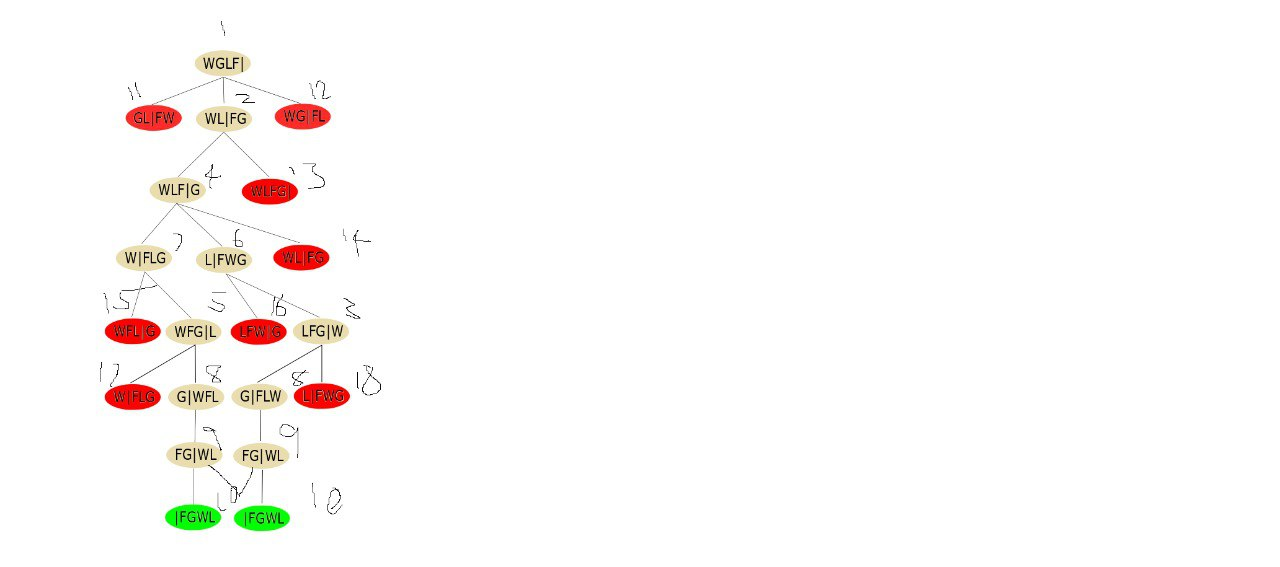

In [113]:
Image(filename='./images/states.jpeg')

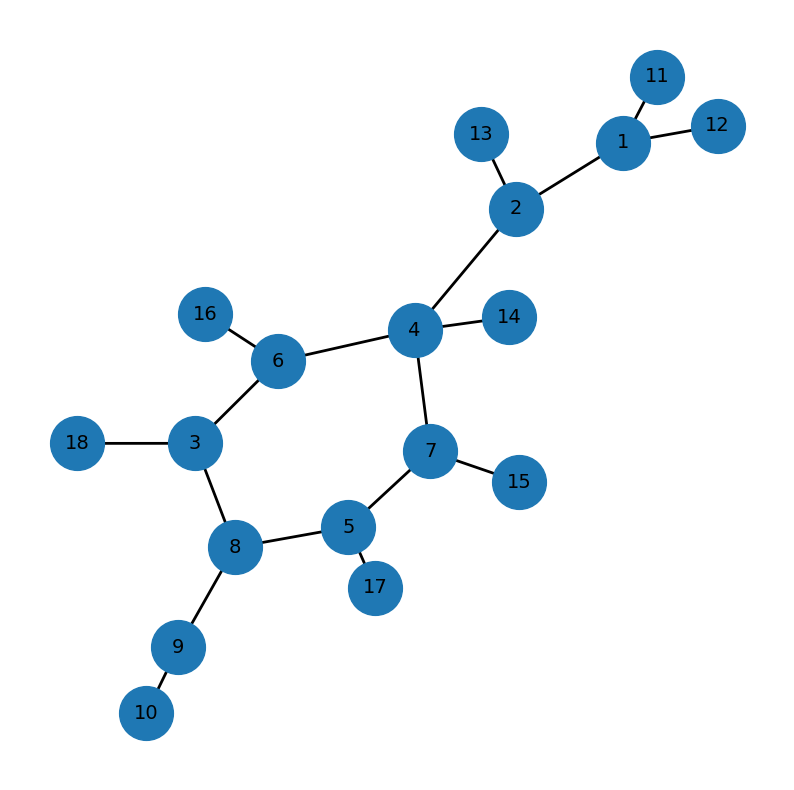

In [114]:
allowed_states = {
    "1" : [{"F", "W", "G", "C"}, {None}],
    "2" : [{"W","C"},{"F","G"}],
    "3" : [{"F","G","C"},{"W"}],
    "4" : [{"F","W","C"},{"G"}],
    "5" : [{"F","W","G"},{"C"}],
    "6" : [{"C"},{"F","W","G"}],
    "7" : [{"W"},{"F","G","C"}],
    "8" : [{"G"},{"F","W","C"}],
    "9" : [{"F","G"},{"W","C"}],
    "10" : [{None},{"F","W","G","C"}],
    "11" : [{"G","C"},{"F","W"}],
    "12" : [{"W","G"},{"F","C"}],
    "13" : [{"W","C","F","G"},{None}],
    "14" : [{"W","C"},{"F","G"}],
    "15" : [{"W","F","C"},{"G"}],
    "16" : [{"C","F","W"},{"G"}],
    "17" : [{"W"},{"F","C","G"}],
    "18" : [{"C"},{"F","W","C"}],
}

moves_graphs = [
    ("1", "2", {"weight":8.1}),     # Farmer + Goat         Left -> Right
    ("1", "11", {"weight":8.1}),    
    ("1", "12", {"weight":8.1}),
    
    ("2", "4", {"weight":5.6}), 
    ("2", "13", {"weight":5.6}), 

    ("4", "6", {"weight":8.6}),     # Farmer + Wolf         Left -> Right
    ("4", "7", {"weight":5.7}), 
    ("4", "14", {"weight":5.7}), 

    ("6", "3", {"weight":8.1}), 
    ("6", "16", {"weight":8.1}), 
    
    ("7", "5", {"weight":8.1}),     # Farmer + Goat         Right -> Left
    ("7", "15", {"weight":8.1}),

    ("3", "8", {"weight":5.7}),
    ("3", "18", {"weight":5.7}),
    
    ("5", "8", {"weight":8.6}),
    ("5", "17", {"weight":8.6}),
    

    ("8", "9", {"weight":5.6}),     # Farmer alone          Right -> Left
    ("9", "10", {"weight":8.1})     # Farmer + Goat         Left -> Right
]
printGraph(moves_graphs)

In [115]:
def aStar_search2(graph, start, goal, heuristics):
    frontier = [(heuristics.getHeuristics(start), start)]
    
    cameFrom = {}  
    gScore = {node: float('inf') for node in allowed_states}  #from start to node
    gScore[start] = 0
    
    fScore = {node: float('inf') for node in allowed_states} 
    fScore[start] = heuristics.getHeuristics(start)

    processed = 0

    while frontier:
        currentFScore, currentNode = min(frontier, key=lambda x: x[0])
        frontier.remove((currentFScore, currentNode))
        
        processed = processed + 1

        print(currentNode)
        if currentNode == goal:
            path = reconstructPath(cameFrom, currentNode)
            return cameFrom, {node: gScore[node] for node in cameFrom}, processed

        for neighbor, properties in getNeighbours(graph, currentNode):
            tentativeGScore = gScore[currentNode] + properties['weight']
            if tentativeGScore < gScore[neighbor]:
                cameFrom[neighbor] = currentNode
                gScore[neighbor] = tentativeGScore
                fScore[neighbor] = tentativeGScore + heuristics.getHeuristics(neighbor)
                                                                                            # if not in the frontier + add
                if all(item[1] != neighbor for item in frontier):
                    frontier.append((fScore[neighbor], neighbor))

    return cameFrom, {node: gScore[node] for node in cameFrom}, processed  # If goal not reached

def reconstructPath(cameFrom, current):
    path = []
    while current in cameFrom:
        path.append(current)
        current = cameFrom[current]
    path.append(current)
    path.reverse()
    return path
    



In [116]:
class FWGC_Heuristics1:
    def __init__(self):
        self.heuristics = {
         "1": 47,
         "2": 41,
         "3": 19,
         "4": 35,
         "5": 17,
         "6": 22,
         "7": 27,
         "8": 10,
         "9": 8,
         "10": 0,
            "11": 100,
            "12": 100,
            "13": 100,
            "14": 100,
            "15": 100,
            "16": 100,
            "17": 100,
            "18": 100
        }

    def getHeuristics(self, node):
        return self.heuristics[node]
            
H1 = FWGC_Heuristics1()
for n in allowed_states.keys():
    h1 = H1.getHeuristics(n)
    print(f"State: {n:2}, Heuristics: {h1}")

State: 1 , Heuristics: 47
State: 2 , Heuristics: 41
State: 3 , Heuristics: 19
State: 4 , Heuristics: 35
State: 5 , Heuristics: 17
State: 6 , Heuristics: 22
State: 7 , Heuristics: 27
State: 8 , Heuristics: 10
State: 9 , Heuristics: 8
State: 10, Heuristics: 0
State: 11, Heuristics: 100
State: 12, Heuristics: 100
State: 13, Heuristics: 100
State: 14, Heuristics: 100
State: 15, Heuristics: 100
State: 16, Heuristics: 100
State: 17, Heuristics: 100
State: 18, Heuristics: 100


In [117]:
performSearch(breadth_first_search, "Breadth First Search (BFS)", moves_graphs, INIT_STATE, GOAL_STATE)
performSearch(depth_first_search, "Depth First Search (DFS)", moves_graphs, INIT_STATE, GOAL_STATE)
performSearch(uniform_cost_search, "Uniform-Cost-Search (UCS)", moves_graphs, INIT_STATE, GOAL_STATE)
performSearch(greedy_search, "Greedy Search", moves_graphs, INIT_STATE, GOAL_STATE, H1)
performSearch(aStar_search2, "A* search", moves_graphs, INIT_STATE, GOAL_STATE, H1)

current_node: 1, goal: 10
current_node: 2, goal: 10
current_node: 11, goal: 10
current_node: 12, goal: 10
current_node: 4, goal: 10
current_node: 13, goal: 10
current_node: 6, goal: 10
current_node: 7, goal: 10
current_node: 14, goal: 10
current_node: 3, goal: 10
current_node: 16, goal: 10
current_node: 5, goal: 10
current_node: 15, goal: 10
current_node: 8, goal: 10
current_node: 18, goal: 10
current_node: 17, goal: 10
current_node: 9, goal: 10
current_node: 10, goal: 10
---------------------------------------------------------------------------------
Breadth First Search (BFS)

Total nodes in graph    : 18
Total nodes visited     : 18 | 100.0%

Final path steps taken  : 8
Path through the Graph :
(start)  1 -> 2 -> 4 -> 6 -> 3 -> 8 -> 9 -> 10 (Goal)
Depth First Search (DFS)

Total nodes in graph    : 18
Total nodes visited     : 14 | 77.77777777777779%

Final path steps taken  : 8
Path through the Graph :
(start)  1 -> 2 -> 4 -> 7 -> 5 -> 8 -> 9 -> 10 (Goal)
Uniform-Cost-Search (UCS)

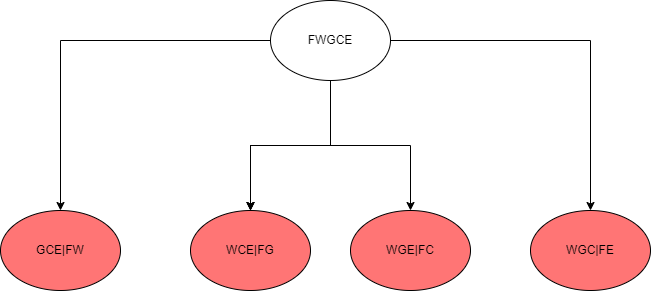

In [118]:
Image(filename='./images/elephant.png')

In [145]:
#Part 3
names = {"F": "Farmer",
         "W": "Wolf",
         "G": "Goat",
         "C": "Cabbage",
         "E": "Elephant"}

forbidden_states = [
    {"W","G"}, 
    {"G","C"}, 
    {"G","C","W"},
    {"E","W","G"}, 
    {"E","G","C"}, 
    {"E","G","C","W"},
    {"E","W"},
    {"E","W","G"},
    {"E","W","C"},
    {"E","W","G","C"}
    ]

# "State": [{Left River Bank State}, {Right River Bank State}]
allowable_states = {
    "1" : [{"F", "W", "G", "C", "E"}, {None}],
    "10" : [{None},{"F","W","G","C", "E"}]
}

moves_graphs = []

In [146]:
print("BFS")
breadth_first_search(moves_graphs, INIT_STATE, GOAL_STATE)
print()
print("DFS")
depth_first_search(moves_graphs, INIT_STATE, GOAL_STATE)
print("UCS")
uniform_cost_search(moves_graphs, INIT_STATE, GOAL_STATE)
print("GDS")
greedy_search(moves_graphs, INIT_STATE, GOAL_STATE, H1)
print("ASS")
aStar_search2(moves_graphs, INIT_STATE, GOAL_STATE, H1)

BFS
current_node: 1, goal: 10
---------------------------------------------------------------------------------
DFS
UCS
No moves left!
GDS
ASS
1


({}, {}, 1)

It will be impossible to move on or have any steps to continue when Elephant that will kill the wolf when unsupervised is added to the puzzle.